# Transient detections

In [64]:
import numpy as np
import matplotlib.pyplot as plt

## Signal generation support functions

In [65]:
def freq(tt,f1,bw,dt):
    return (f1+bw/2/dt*tt)*(tt>-dt/2)*(tt<dt/2)

def ampl(tt,sig):
    return np.exp(-1/2*(tt/sig)**2)

def sig(tt,to,f1,bw,dt,sig):
    return ampl(tt-to,sig)*np.sin(2*np.pi*freq(tt-to,f1,bw,dt)*(tt-to))


## generate signal

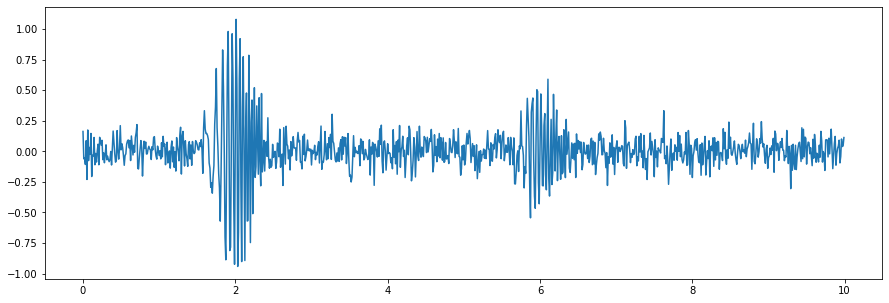

In [66]:
fs = 96
te=10
tt = np.arange(0,te,1/fs)
ndat=len(tt)

fo = 20
bw = 40
dt1 = 1
dt2 = dt1/5

np.random.seed(1)       # only to ensure same noise signal
ss=np.random.normal(0, 0.1, ndat)
ss+=sig(tt,te*0.2,fo,bw,dt1,dt2)
ss+=0.5*sig(tt,te*0.6,fo,bw,dt1,dt2)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,ss);

## Transient detector
Transients are typically peaky signals and are usually found after searching for extreme values (peaks).
For this one first considers the signal power (amplitude squared)


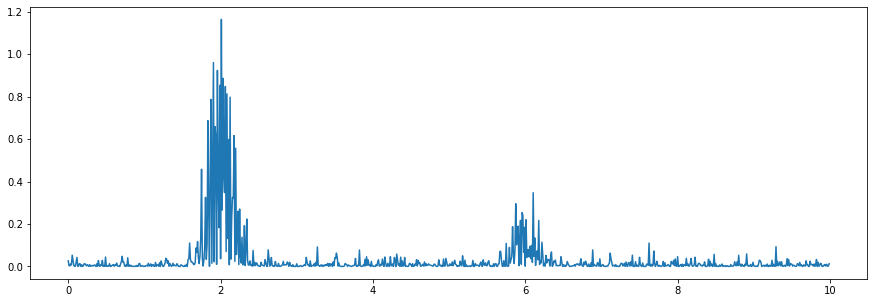

In [67]:
yy=ss**2
fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,yy);

From the figure, it seams obvious that there are multiple local maxima surrounding the global maximum of a signal (here around t=2 and t=6). These local maxima are then also seperated ba rather small values. A simple threshold detector would be very fragmented, requiring additional algrorithms to clean-up the detections.

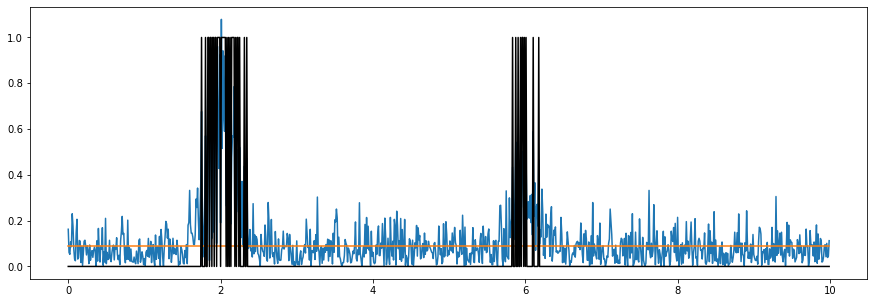

In [68]:
no=np.sum(yy[:100],0)/100   # noise estimate
dd=yy>20*no                 # threshold detector

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,np.sqrt(yy));
plt.plot(tt,np.sqrt(no)+0*tt)
plt.plot(tt,dd,'k');

### Leaky peak detector

Let $y(k)=|x(k)|^2$ be the instantaneous power of a time series $x(k)$

the one can estimate a leaky peak detector output $z(k) as

\begin{equation}
z(k) = max(y(k),\alpha z(k-1))
\end {equation}
where $\alpha$ is a factor $0\lt\alpha\lt1$ describing the leak of the peak of the peak detector. For $\alpha=0$ the peak detector follows the instantaneous power $y(k)$ and for $\alpha=0$ the peak detector only inceases for increasing instantaneous power $y(k)$.

This function follows increasing signals immediately, but does decrease only slowly. The relative deceasing factor is determined emperically. 

The porpose of the leaky peak detector is to generate a detection function that is insentitive to short drop-outs of instantaneous power.

In [69]:
def peak1(xx,leak):
    ndat=len(xx)
    yy=xx.copy()
    for ii in range(1,ndat):
        yy[ii]=np.maximum(xx[ii],yy[ii-1]*leak)
    return yy


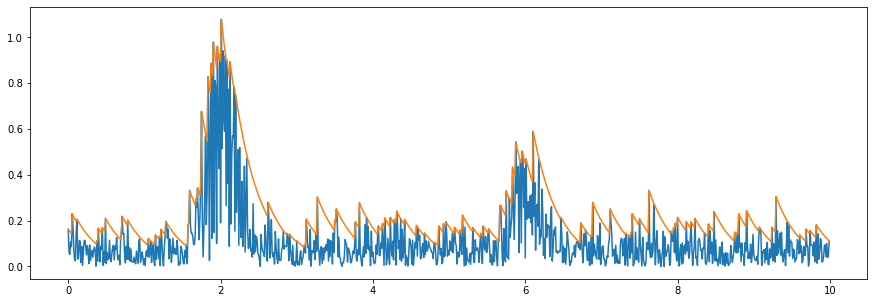

In [70]:
# test the leaky peak tracker
zz=peak1(np.abs(ss),0.97)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,np.abs(ss));
plt.plot(tt,zz);


## Page test detector
The page test detector is a derivation of Wald's sequential probability ratio test (SPRT), where decisions on presence and absence of signal are not necessarily made for every sample but can be deferred after further sampling.

Let $s(k)$ be the test variable then we consider three situations
- $s(k) > th$:   signal detection and limiting $s(k)=th$
- $s(k) < 0$:   noise detection and limiting $s(k)=0$

in all other cases the test variable $s(k)$ will be updated according to
- $s(k) = s(k-1) + (y(k)/n(k)-b)$

whereby $y(k)$ is the signal estimate and $n(k)$ is the noise estimate. Therefore, $y(k)/n(k)$ is the signal-to-noise ratio SNR.

THe noise estimate $n(k)$ is updated in absence of signal  detection according to an exponential moving average (EMA)
- $n(k)= n(k-1) + \gamma(y(k)-n(k-1))$

where $\gamma$ is the factor controllong the EMA

In [71]:
def pageTest1(yy,th,bb,gg,nt):
    ss=0*yy
    dd=0*yy
    nn=0*yy
    sn=0*yy

    no=np.mean(yy[:100],0)
    nn[0]=no
    #
    sn[0]=yy[0]/nn[0]
    #
    ndat=len(yy)
    
    it=0
    for ii in range(1,ndat):
        sn[ii]=yy[ii]/nn[ii-1]
        ss[ii]= ss[ii-1]+(sn[ii]-bb)
        if (ss[ii]>th):
            ss[ii]=th
            dd[ii]=1
            if ii<(it+nt):
                ss[it:ii]=th
                dd[it:ii]=1
            it=ii
        if (ss[ii]<0):
            ss[ii]=0
            nn[ii]=nn[ii-1]+gg*(yy[ii]-nn[ii-1])
            it=ii
        else:
            nn[ii]=nn[ii-1]
                
    return dd,nn


Start of detection is anticipated to last noise detection if no noise decision is made for at most $nt$ samples

            if ii<(it+nt):
                ee[it:ii]=th
                dd[it:ii]=1

wherby $it$ is indicating the last noise decision. This allows also to bridge small drop-outs (holes) during the detection.

### Test of Page-test
The following snippet applies the page test detector with some ad-hoc parameter settings that for real data have to determined such that the detection performace is adequate.

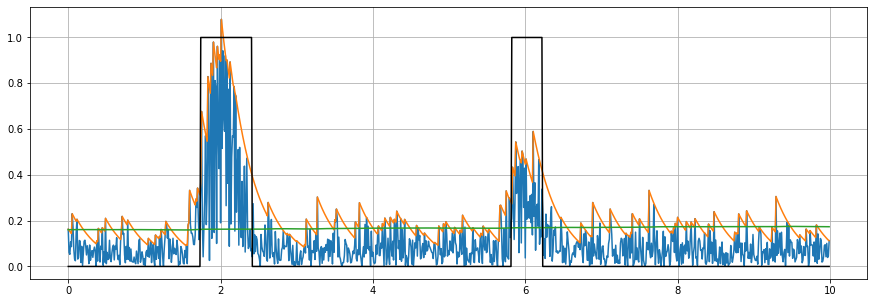

In [72]:
th=20
bb=6
aa=1e-3
nt=100
dd,nn = pageTest1(zz**2,th,bb,aa,nt)

fig = plt.figure("figure.figsize",[15,5])
plt.plot(tt,np.abs(ss));
plt.plot(tt,zz);
plt.plot(tt,np.sqrt(nn));
plt.plot(tt,dd,'k');
plt.grid(True)

The overall detection performance is determined by five parameters 
- peak detector
  - leak factor (gg=0.97)
- page test
  - detection threshold (th=20)
  - snr detection bias (bb=6)
  - noise estimation innovation factor (aa=1/1000)
  - minimal separation between detections (samples) (nt=100)

The values of these parameters are typically selected empirically.